<h2 align='center'>IDVE Assignment 1

 **Kulile Bhotile**: 2104349 </br>
 **Thabelang Ncube**: 1918469</br>
 **Lindelani Dlamini**: 1898593</br>
 **Lindani Dlamini**: 1712359</br>
 **Pamela Segana**: 2265335
</h2>

### **Connect to the Drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### **Imports**

In [ ]:
!pip install fuzzywuzzy

In [ ]:
import os
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from fuzzywuzzy import fuzz
from fuzzywuzzy import process

### **Helpers**

In [ ]:
def combine_csv_on_single_federation(directory_path: str):

    csv_files = []
    for root, dirs, files in os.walk(directory_path):
        if root != directory_path:
            for file in files:
                if file.endswith('.csv') and file == 'entries.csv':
                    csv_files.append(os.path.join(root, file))

    combined_df = pd.DataFrame()

    for csv_file in csv_files:
        df = pd.read_csv(csv_file)
        combined_df = pd.concat([combined_df, df], ignore_index=True, sort=False, join='outer')

    return combined_df

In [ ]:
def ipf_point_score(equipment, sex, bodyweight_kg, total_kg):
    equipment_mapping = {
        'Single-ply': 'equipped',
        'Double-ply': 'equipped',
        'Unlimited': 'equipped',
        'Raw': 'classic',
        'Wraps': 'classic',
    }

    sex_coefficients = {
        'M': {
            'equipped': (1236.25115, 1449.21864, 0.01644),
            'classic': (1199.72839, 1025.18162, 0.00921),
        },
        'F': {
            'equipped': (758.63878, 949.31382, 0.02435),
            'classic': (610.32796, 1045.59282, 0.03048),
        },
    }

    mapped_equipment = equipment_mapping.get(equipment)

    if mapped_equipment not in sex_coefficients.get(sex, {}):
        raise ValueError("Invalid equipment or sex value")

    A, B, C = sex_coefficients[sex][mapped_equipment]

    ipf_score = 100 / (A - B * math.exp(-C * bodyweight_kg)) * total_kg

    return ipf_score

In [ ]:
def wilks_coefficent_score(sex, weight_class, bodyweight_kg, total_kg):
    coefficients = {
        'M': (47.46178854, 8.472061379, 0.07369410346, -0.001395833811, 7.07665973070743E-06, -1.20804336482315E-08),
        'F': (-125.4255398, 13.71219419, -0.03307250631, -0.001050400051, 9.38773881462799E-06, -2.3334613884954E-08)
    }
    if sex not in coefficients:
        raise ValueError("Invalid sex value")
    a, b, c, d, e, f = coefficients[sex]
    wilks_score = (
        600
        / (a + b * bodyweight_kg + c * bodyweight_kg ** 2 + d * bodyweight_kg ** 3 + e * bodyweight_kg ** 4 + f * bodyweight_kg ** 5)
    ) * total_kg

    return wilks_score

In [ ]:
def get_wilks_and_ipf(df, measure_column):
  df['Wilks'] = df.apply(
    lambda row: wilks_coefficent_score(
        row['Sex'], row['WeightClassKg'],
        row['BodyweightKg'],
        row[measure_column]
        ),
     axis=1
    )
  df['IPF'] = df.apply(
      lambda row: ipf_point_score(
          row['Equipment'],
          row['Sex'],
          row['BodyweightKg'],
          row[measure_column]),
      axis=1
      )

In [ ]:
def find_max_entry_in_a_row(row):
    filter_columns = ['Squat1Kg', 'Squat2Kg', 'Squat3Kg', 'Best3SquatKg',
                      'Bench1Kg', 'Bench2Kg', 'Bench3Kg', 'Best3BenchKg',
                      'Deadlift1Kg', 'Deadlift2Kg', 'Deadlift3Kg', 'Best3DeadliftKg']
    return row[filter_columns].max()

### 1. **Combine the data in your dataset (subset of the data)**

We chose:


1.   JPA federation
2.   NPAJ federation
3.   UAEPA federation

In [ ]:
df = combine_csv_on_single_federation('/content/drive/MyDrive/federations')

In [ ]:
df.size

621210

In [ ]:
df.head(10)

,Name,BirthDate,BirthYear,Sex,Division,BodyweightKg,WeightClassKg,Deadlift1Kg,Deadlift2Kg,Deadlift3Kg,...,Bench1Kg,Bench2Kg,Bench3Kg,Best3BenchKg,JapaneseName,Team,Squat4Kg,Bench4Kg,Deadlift4Kg,Country
0,Shaniqueka Allman,NaN,1992.0,F,FR-O,65.1,69,104.33,113.40,124.74,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Fiona Binns,NaN,1988.0,F,FR-O,75.9,76,124.74,136.08,147.42,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Aiesha Denton,NaN,1998.0,F,FR-O,104.2,84+,163.29,183.70,-206.38,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Ayana Duhaney,NaN,1992.0,F,FR-O,77.2,84,147.42,158.76,172.37,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Jodi-Kay Hunter,NaN,1990.0,F,FR-O,66.6,69,129.27,142.88,147.42,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,Chevaneese Powell,NaN,1984.0,F,FR-O,72.0,76,142.88,158.76,-165.56,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,Shrona Scott,NaN,1989.0,F,FR-O,67.7,69,83.91,102.06,111.13,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,Tesi Scott,NaN,1990.0,F,FR-O,83.6,84,145.15,156.49,165.56,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,Nadesha Thompson,NaN,1984.0,F,FR-O,69.1,76,120.20,133.81,136.08,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,Mervin Barrett,NaN,1985.0,M,MR-O,86.8,93,224.53,-247.21,247.21,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 2. **Convert all weights to a common unit (kg or lbs).**

All the values in the dataset are already in kilograms. We will leave them in `kg`s. </br>
weight class is of type `object` thus we will convert it to float. </br>

The only problem we are facing is that we have to have a standard conversion for classes which have a plus (`+`) oparend.

We will apply the below logic to solve the problem:

if `weight classes = 125` convert it to`float(weight classes)` </br>
if `weight classes = 125+` remove the `+` and `weight classes += 0.01 ` convert it to`float(weight classes)`



In [ ]:
def WeightClassKg_Converter(value):
    if isinstance(value, str) and value.endswith('+'):
        return float(value.rstrip('+')) + 0.01
    else:
        try:
            return float(value)
        except (ValueError, TypeError):
            return np.nan

df['WeightClassKg'] = df['WeightClassKg'].apply(WeightClassKg_Converter)

### 3. **For each performance of each competition of each lifter compute columns giving the best performance on each lift.**

In [ ]:

# we can do better here
def best_lift_performance(group):
    best_squat = group[['Squat1Kg', 'Squat2Kg', 'Squat3Kg', 'Squat4Kg', 'Best3SquatKg']].max().max()
    best_benchpress = group[['Bench1Kg', 'Bench2Kg', 'Bench3Kg', 'Bench4Kg', 'Best3BenchKg']].max().max()
    best_deadlift = group[['Deadlift1Kg', 'Deadlift2Kg', 'Deadlift3Kg', 'Deadlift4Kg', 'Best3DeadliftKg']].max().max()

    return pd.Series({
        'BestSquat': best_squat,
        'BestBenchpress': best_benchpress,
        'BestDeadlift': best_deadlift
        })

grouped = df.groupby(['Name', 'Event'])
best_lifts_df = grouped.apply(best_lift_performance).reset_index()

best_performance = df.merge(best_lifts_df, on=['Name', 'Event'])

best_performance[['Name', 'Event', 'BestSquat', 'BestBenchpress', 'BestDeadlift']].drop_duplicates(keep='first')

,Name,Event,BestSquat,BestBenchpress,BestDeadlift
0,Shaniqueka Allman,D,NaN,NaN,124.74
1,Fiona Binns,D,NaN,NaN,147.42
2,Aiesha Denton,D,NaN,NaN,183.70
3,Ayana Duhaney,D,NaN,NaN,172.37
4,Jodi-Kay Hunter,D,NaN,NaN,147.42
...,...,...,...,...,...
4892,Mishaal Al Rais,SBD,172.5,115.0,265.00
4893,Saif Al Shemeili,SBD,157.5,147.5,215.00
4894,Abhinav Malhotra,SBD,182.5,110.0,220.00
4895,Dario Ghersi,SBD,230.0,155.0,290.00


### 4. **Engineer wilks and IPF score columns**

In [ ]:
get_wilks_and_ipf(df, 'TotalKg')
df[['Name', 'Sex', 'BodyweightKg', 'TotalKg', 'Wilks', 'IPF']].head(10)

,Name,Sex,BodyweightKg,TotalKg,Wilks,IPF
0,Shaniqueka Allman,F,65.1,124.74,156.379827,26.735211
1,Fiona Binns,F,75.9,147.42,170.659281,29.082849
2,Aiesha Denton,F,104.2,183.70,191.363423,32.417301
3,Ayana Duhaney,F,77.2,172.37,198.041608,33.737515
4,Jodi-Kay Hunter,F,66.6,147.42,182.399543,31.167013
5,Chevaneese Powell,F,72.0,158.76,188.446984,32.147999
6,Shrona Scott,F,67.7,111.13,136.244204,23.271930
7,Tesi Scott,F,83.6,165.56,184.191061,31.324419
8,Nadesha Thompson,F,69.1,136.08,164.988188,28.169497
9,Mervin Barrett,M,86.8,247.21,193.280797,33.460065


### 5. **Compute correlations between these two features (walks and IPF)**

In [ ]:
print('correlation =', round(df['IPF'].corr(df['Wilks']), 5))

correlation = 0.98602


### 6. **Compute mean, modes, variance, inter-quartile ranges and so forth for both walks and IPF**

In [ ]:
mode = df[['Wilks', 'IPF']].mode().iloc[0].to_frame().rename(columns={0: 'mode'})
stats = df[['Wilks', 'IPF']].describe().T
iqr = (stats['75%'] - stats['25%']).to_frame().rename(columns={0: 'iqr'})

pd.concat([stats, mode, iqr],axis=1)

,count,mean,std,min,25%,50%,75%,max,mode,iqr
Wilks,18471.0,282.628605,168.41106,32.302351,122.461432,261.955892,433.299233,798.985611,92.448681,310.837800
IPF,18471.0,45.201224,26.83413,5.529879,19.887994,41.865118,70.185204,111.245988,16.145259,50.297209


### 7. **Filter to only using a single performance for each lifter (best or most recent) and repeat the above calculations.**

In [ ]:
dfx = df.copy()
# find best performance of each athlete/lifter
dfx['BestPerformance'] = dfx.apply(find_max_entry_in_a_row, axis=1)

# calculate wilks and ipf score using the best performance
get_wilks_and_ipf(dfx, 'BestPerformance')
dfx[['Name', 'Sex', 'BodyweightKg', 'BestPerformance', 'Wilks', 'IPF']].head(10)

,Name,Sex,BodyweightKg,BestPerformance,Wilks,IPF
0,Shaniqueka Allman,F,65.1,124.74,156.379827,26.735211
1,Fiona Binns,F,75.9,147.42,170.659281,29.082849
2,Aiesha Denton,F,104.2,183.70,191.363423,32.417301
3,Ayana Duhaney,F,77.2,172.37,198.041608,33.737515
4,Jodi-Kay Hunter,F,66.6,147.42,182.399543,31.167013
5,Chevaneese Powell,F,72.0,158.76,188.446984,32.147999
6,Shrona Scott,F,67.7,111.13,136.244204,23.271930
7,Tesi Scott,F,83.6,165.56,184.191061,31.324419
8,Nadesha Thompson,F,69.1,136.08,164.988188,28.169497
9,Mervin Barrett,M,86.8,247.21,193.280797,33.460065


In [ ]:
# find the correlation
print('\nCorrelation =', round(dfx['IPF'].corr(dfx['Wilks']), 5), '\n\n')

# find the stat summary for wilks and ipf
mode = dfx[['Wilks', 'IPF']].mode().iloc[0].to_frame().rename(columns={0: 'mode'})
stats = dfx[['Wilks', 'IPF']].describe().T
iqr = (stats['75%'] - stats['25%']).to_frame().rename(columns={0: 'iqr'})
pd.concat([stats, mode, iqr],axis=1)


Correlation = 0.97837 




,count,mean,std,min,25%,50%,75%,max,mode,iqr
Wilks,19421.0,143.235188,65.263324,-245.693103,117.467134,148.586377,181.547621,308.115218,172.672513,64.080487
IPF,19421.0,22.913739,10.145459,-38.272264,19.043543,23.616106,28.856965,46.840416,21.956223,9.813422


### 8. **Plot lifter body-weights**

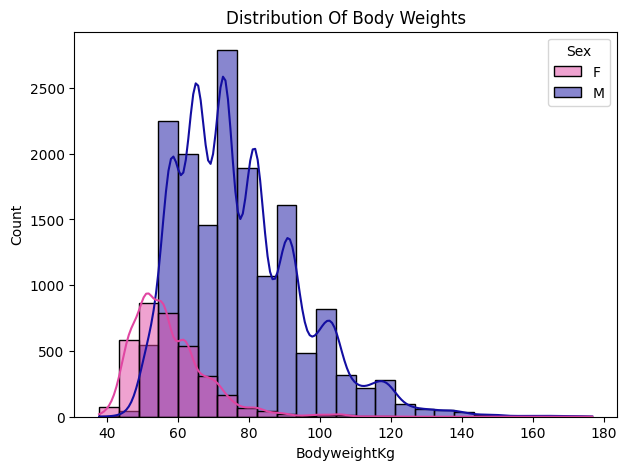

In [ ]:
plt.figure(figsize=(7, 5))
sns.histplot(
      data=df,
      x='BodyweightKg',
      bins=25,
      hue='Sex',
      kde=True,
      palette={'M': '#130ea1', 'F': '#e046a2'}
    )
plt.title("Distribution Of Body Weights")
plt.show()

**Male Distribution**:

*Shape*: Normal-shaped or bell-shaped distributions are quite common in real-world data, especially when dealing with physical attributes like bodyweight.

*Skewness*: The skewness indicates that the distribution is not perfectly symmetrical. In the case of males, the distribution is skewed to the right, meaning it has a long tail on the right-hand side. This suggests that there are a few males who weigh significantly more than the average.

*Peak at 75kg*: The peak around 70kg is the mode of the distribution, indicating that 75kg is the most common bodyweight among males in the dataset. This is a typical finding as powerlifting includes weight classes, and many competitors aim to compete in specific weight categories where 75kg might be a common threshold.


**Female Distribution**:

*Similar but Smaller Peak*: The presence of a similar shape to the male distribution but with a smaller peak around 55kg suggests that 55kg is the most common bodyweight among females in the dataset. This is consistent with the idea that powerlifting also has weight classes for females, and 55kg could be a common threshold for one of these classes.

*Skewness*: Similar to males, the female distribution is also skewed to the right, indicating that there are a few females who weigh significantly more than the average.

###9. **Make a correlogram**

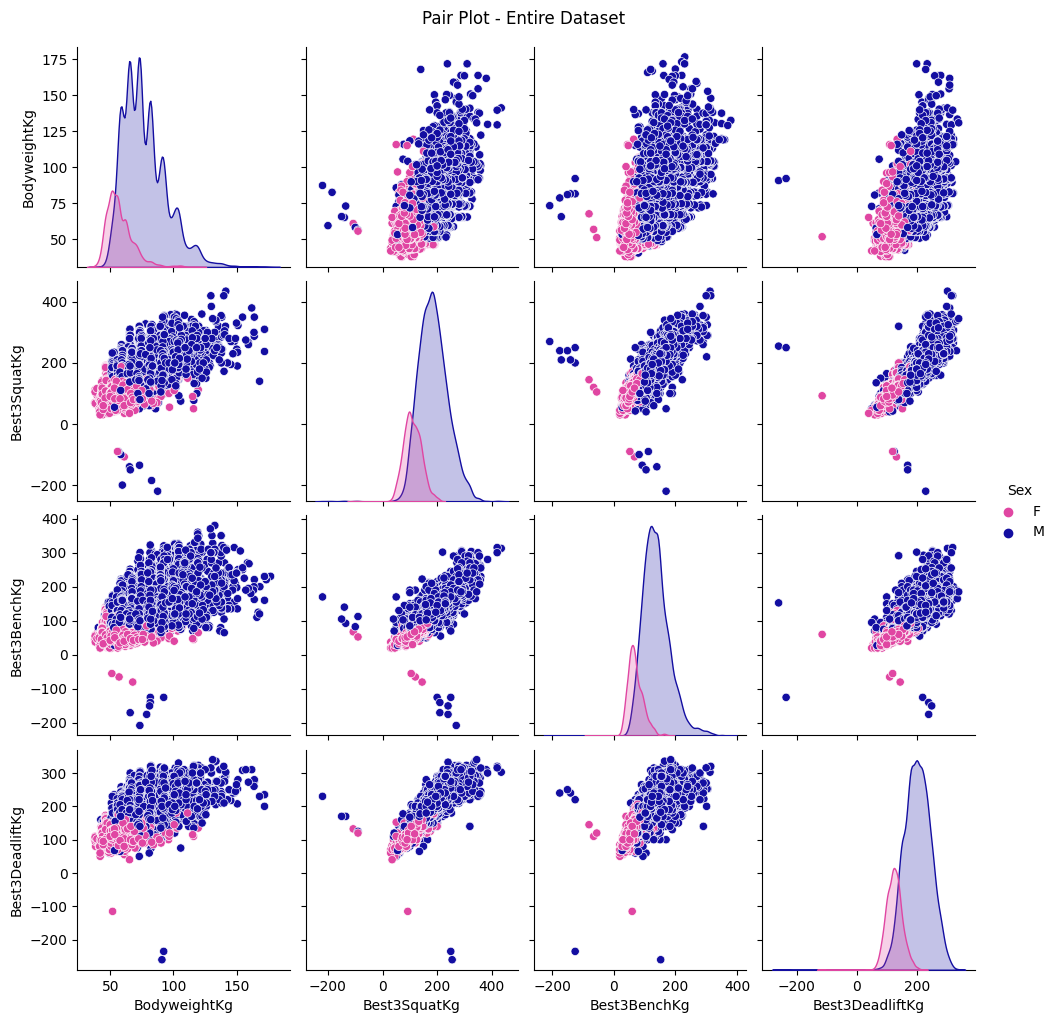

In [ ]:
columns_to_include = ['BodyweightKg', 'Best3SquatKg', 'Best3BenchKg', 'Best3DeadliftKg']

sns.pairplot(df, vars=df[columns_to_include], hue='Sex', palette={'M': '#130ea1', 'F': '#e046a2'})
plt.suptitle('Pair Plot - Entire Dataset', y=1.02)
plt.show()

For one, we can clearly see there are more males than females in our dataset, and that the males tend to generally weigh more; & bench, squat and deadlift heavier weights.

Also, if we were to ignore a few of the outlying data points, we can observe a somewhat weak & positive linear correlation between the Body Weight; and all 3 Benching, Squating, and Deadlifting. It seems, for the most part, the more a lifter weighs the more weight they can carry.

And if we were to still ignore the outliers, there also seems to be some weak positive linear correlation between the different comptetions. That is, the more a lifter can Deadlift, seemingly most likely the more they can also Bench and Squat. As with both Benching and Squating in relation to the others.

In [ ]:
def pair_plot_gender(subset_df, columns_to_include, gender):
  if not subset_df.empty:
    sns.pairplot(subset_df, vars=subset_df[columns_to_include], hue='Equipment')
    plt.suptitle(f'Pair Plot - Gender: {gender}', y=1.02)
    plt.show()

In [ ]:
def pair_plot_equipment(subset_df, columns_to_include, equipment):
  if not subset_df.empty:
      sns.pairplot(subset_df, vars=subset_df[columns_to_include], hue='Sex', palette={'M': '#130ea1', 'F': '#e046a2'})
      plt.suptitle(f'Pair Plot - Equipment: {equipment}', y=1.02)
      plt.show()

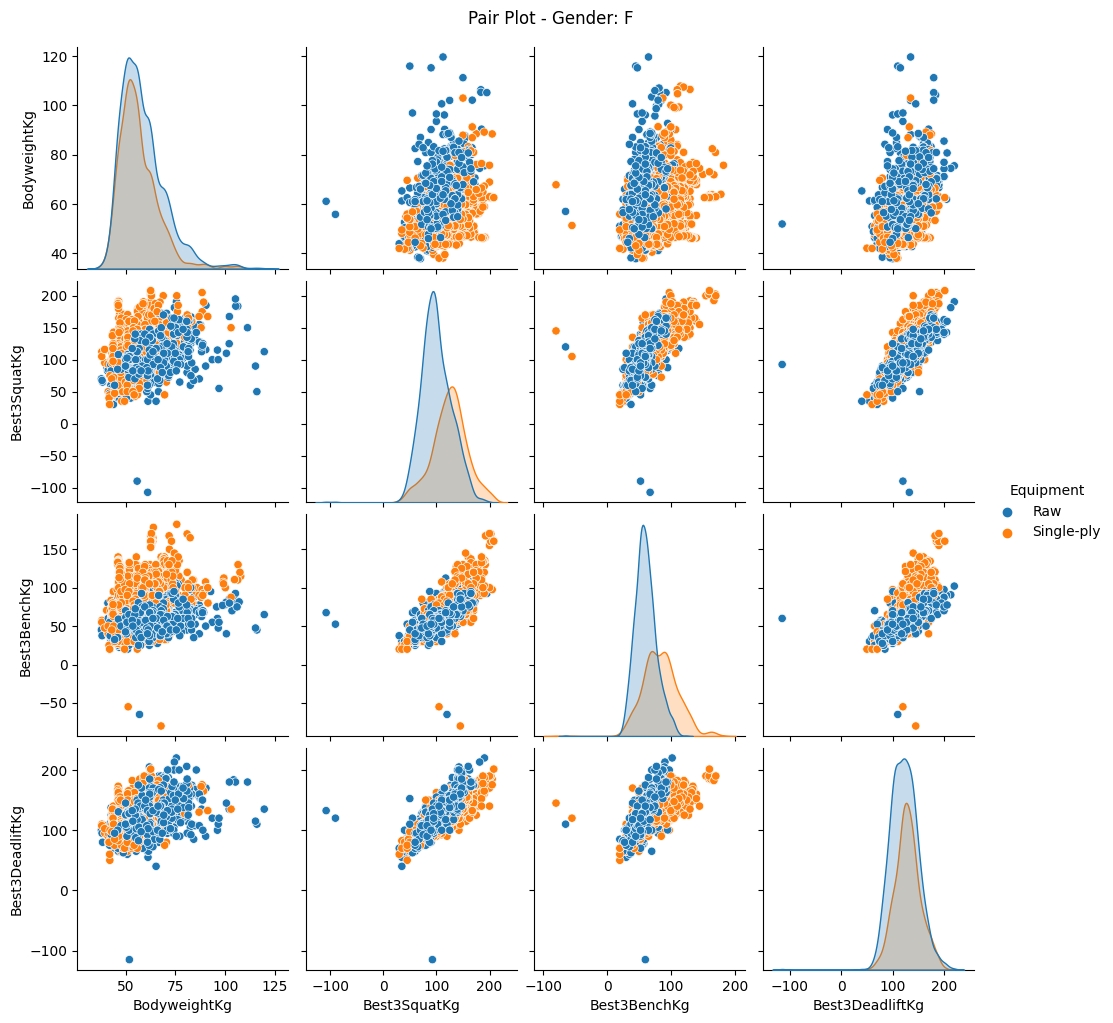

In [ ]:
gender = 'F'
subset_df = df[(df['Sex'] == gender)]
pair_plot_gender(subset_df, columns_to_include, gender)

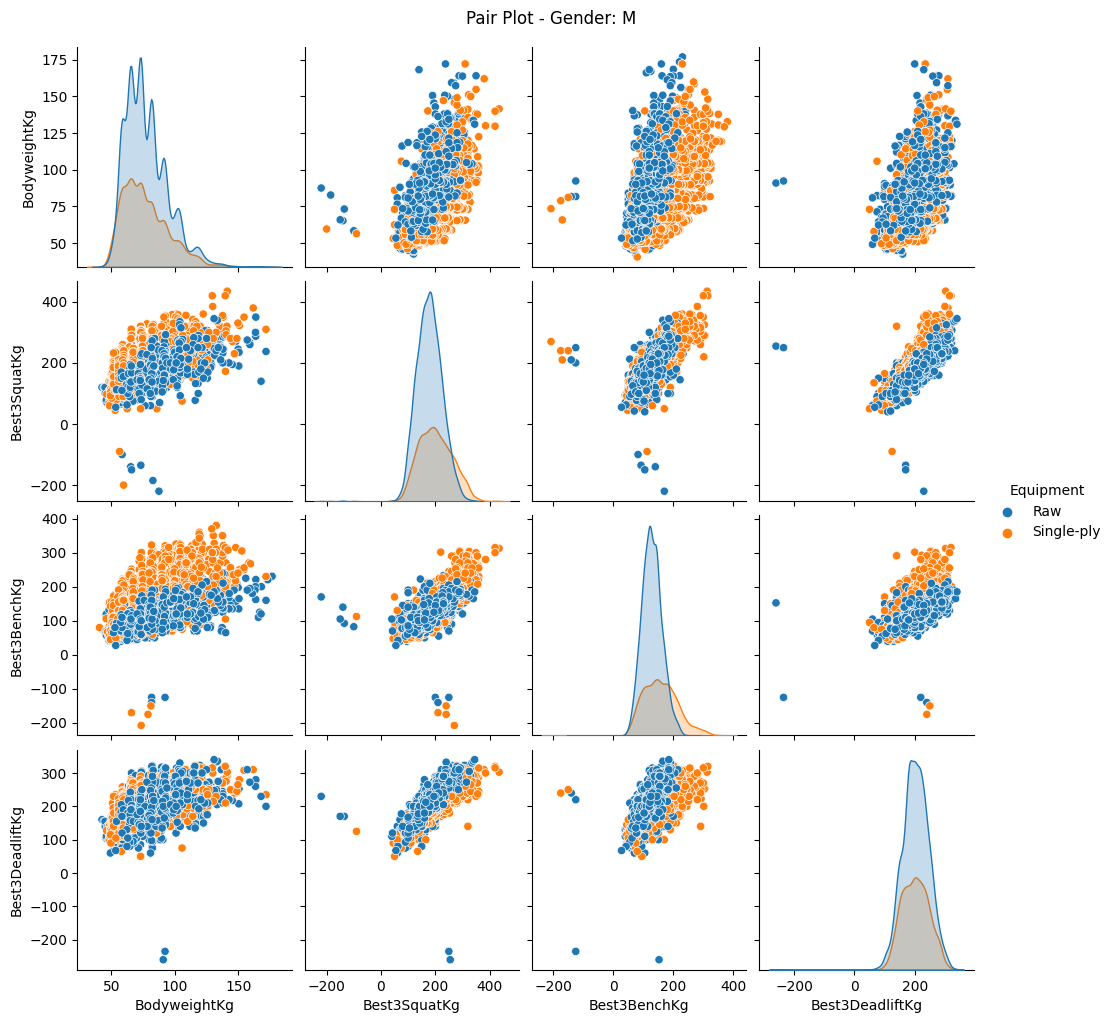

In [ ]:
gender = 'M'
subset_df = df[(df['Sex'] == gender)]
if not subset_df.empty:
    sns.pairplot(subset_df, vars=subset_df[columns_to_include], hue='Equipment')
    plt.suptitle(f'Pair Plot - Gender: {gender}', y=1.02)
    plt.show()

It seems most of the lifters chose to use Raw equipment. More so than Single-Ply equipment. Especially the males (in relation to both equipment).

For Benching, it seems lifters (both male and female) that accounted for heavier Benching records were mostly using Single Ply equipment. This is more evident in males, as they account for most of the lifters. This is also true, even though it appears most of the lifters were using Raw equipment for their Benching.

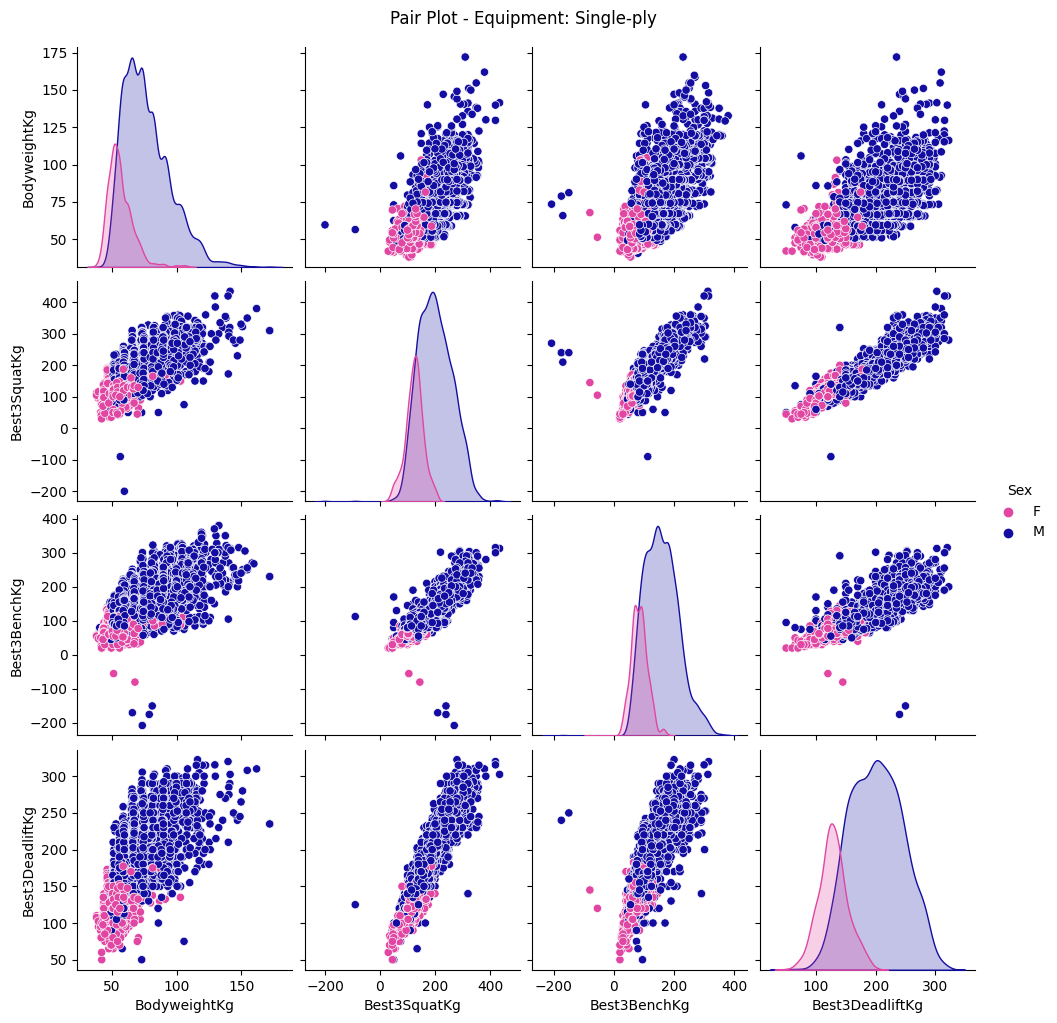

In [ ]:
equipment = 'Single-ply'
subset_df = df[(df['Equipment'] == equipment)]
pair_plot_equipment(subset_df, columns_to_include, equipment)

For Single Ply equipment users, there seems to be a strong positive linear correlation between the amount of weight Deadlifted by competitors and the amount of weight they Squat & Bench. It seems the more weight a lifter Squats and/or Benches, mot likely the more weight they will also Deadlift.

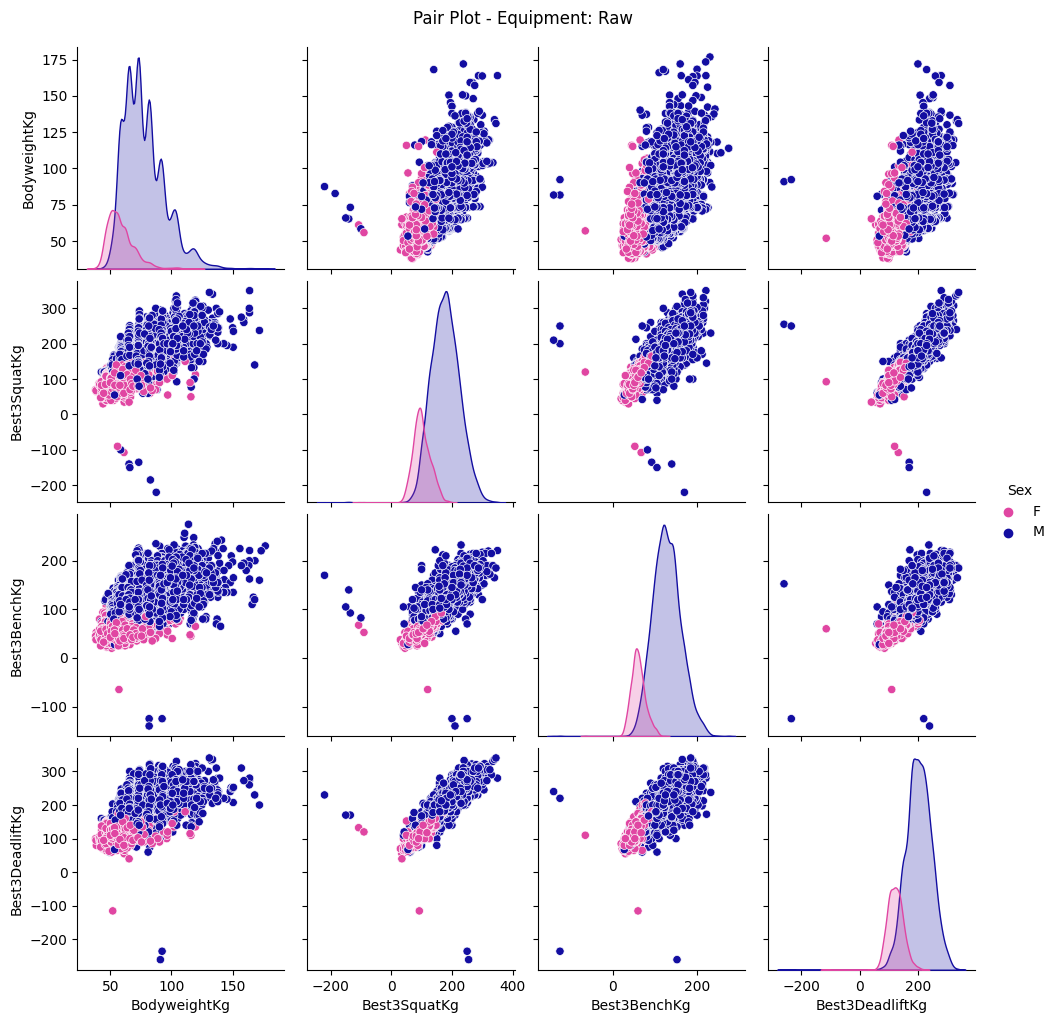

In [ ]:
equipment = 'Raw'
subset_df = df[(df['Equipment'] == equipment)]
pair_plot_equipment(subset_df, columns_to_include, equipment)

We will apply log transformations to remove outliers using log transformations and then calculate linear correlations between bodyweight, squat, benchpress, and deadlift based on gender category and equipment used.

In [ ]:
df_corr = df.copy()

In [ ]:
small_constant = 1  # Small constant to handle zero or negative values
for column in columns_to_include:
    df_corr[column] = np.log(df_corr[column] + small_constant)

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


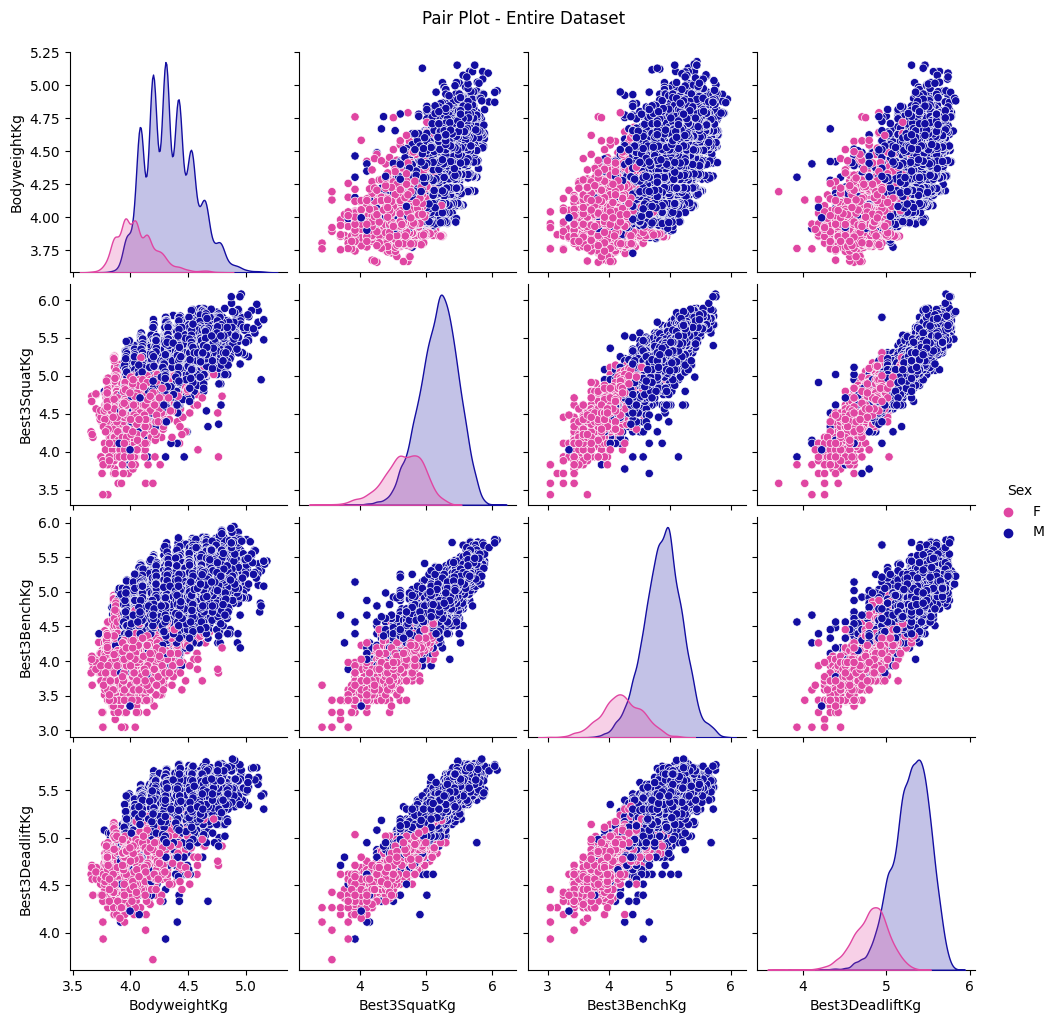

In [ ]:
sns.pairplot(df_corr, vars=df_corr[columns_to_include], hue='Sex', palette={'M': '#130ea1', 'F': '#e046a2'})
plt.suptitle('Pair Plot - Entire Dataset', y=1.02)
plt.show()

In [ ]:
def correlation_matrix(gender, equipment):
    filtered_df = df_corr[(df['Sex'] == gender) & (df['Equipment'] == equipment)]

    correlation_matrix = filtered_df[columns_to_include].corr()
    # print(correlation_matrix)

    plt.figure(figsize=(8, 6))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
    plt.title('Linear Correlations - Bodyweight, Squat, Bench Press, Deadlift')
    plt.show()

### Men, Raw

                 BodyweightKg  Best3SquatKg  Best3BenchKg  Best3DeadliftKg
BodyweightKg         1.000000      0.658947      0.581653         0.552871
Best3SquatKg         0.658947      1.000000      0.808516         0.882218
Best3BenchKg         0.581653      0.808516      1.000000         0.760085
Best3DeadliftKg      0.552871      0.882218      0.760085         1.000000


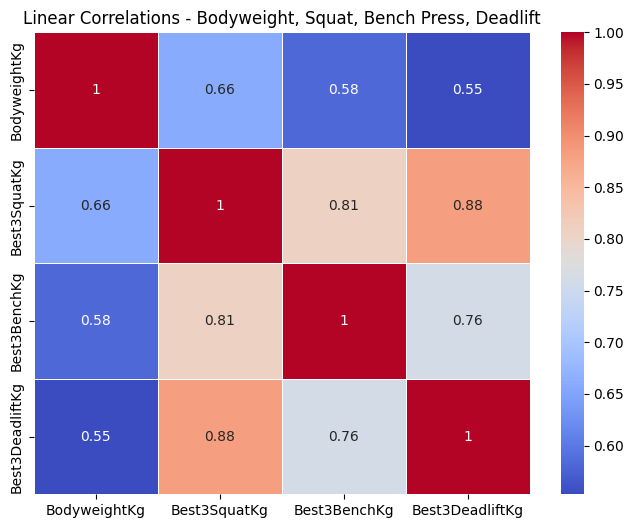

In [ ]:
correlation_matrix('M', 'Raw')

**Bodyweight vs. Lifts**:

*BodyweightKg vs. Best3SquatKg (0.659)*: There is a moderate positive correlation between a lifter’s bodyweight and their best squat performance. This means that, on average, as bodyweight increases, so does squat performance.

*BodyweightKg vs. Best3BenchKg (0.582)*: There is a moderate positive correlation between bodyweight and best bench press performance. As bodyweight increases, bench press performance tends to increase as well.

*BodyweightKg vs. Best3DeadliftKg (0.553)*: A moderate positive correlation is observed between bodyweight and best deadlift performance. As bodyweight increases, deadlift performance tends to increase as well.

**Lifts vs. Each Other**:

*Best3SquatKg vs. Best3BenchKg (0.809)*: There is a strong positive correlation between best squat and best bench press performance. Lifters who perform well in squats tend to perform well in bench presses.

*Best3SquatKg vs. Best3DeadliftKg (0.882)*: There is a strong positive correlation between best squat and best deadlift performance. Lifters who perform well in squats also tend to perform well in deadlifts.

*Best3BenchKg vs. Best3DeadliftKg (0.760)*: There is a strong positive correlation between best bench press and best deadlift performance. Lifters who perform well in bench presses also tend to perform well in deadlifts.

In summary, the correlations in this matrix indicate moderate to strong positive relationships between these variables. This means that as one variable increases, the others tend to increase as well. Without implying causation, these correlations suggest that bodyweight has a significant influence on lift performance, and there are strong associations between the performance of different lifts.

### Male, Single-Ply

                 BodyweightKg  Best3SquatKg  Best3BenchKg  Best3DeadliftKg
BodyweightKg         1.000000      0.650556      0.627604         0.593498
Best3SquatKg         0.650556      1.000000      0.877685         0.899709
Best3BenchKg         0.627604      0.877685      1.000000         0.815301
Best3DeadliftKg      0.593498      0.899709      0.815301         1.000000


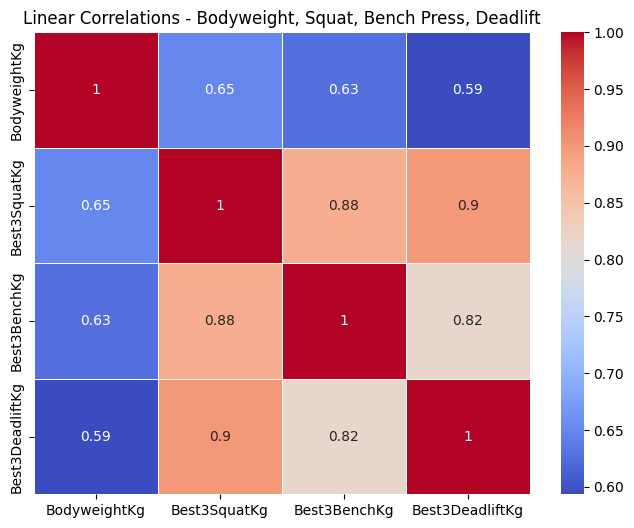

In [ ]:
correlation_matrix('M', 'Single-ply')

**Bodyweight vs. Lifts**:

*BodyweightKg vs. Best3SquatKg (0.651)*: There is a moderate positive correlation between a lifter’s bodyweight and their best squat performance. This means that, on average, as bodyweight increases, so does squat performance.

*BodyweightKg vs. Best3BenchKg (0.628)*: There is a moderate positive correlation between bodyweight and best bench press performance. As bodyweight increases, bench press performance tends to increase as well.

*BodyweightKg vs. Best3DeadliftKg (0.593)*: A moderate positive correlation is observed between bodyweight and best deadlift performance. As bodyweight increases, deadlift performance tends to increase as well.

**Lifts vs. Each Other**:

*Best3SquatKg vs. Best3BenchKg (0.878)*: There is a strong positive correlation between best squat and best bench press performance. Lifters who perform well in squats tend to perform well in bench presses.

*Best3SquatKg vs. Best3DeadliftKg (0.900)*: There is a very strong positive correlation between best squat and best deadlift performance. Lifters who perform well in squats also tend to perform well in deadlifts.

*Best3BenchKg vs. Best3DeadliftKg (0.815)*: There is a strong positive correlation between best bench press and best deadlift performance. Lifters who perform well in bench presses also tend to perform well in deadlifts.

### Female, Raw

                 BodyweightKg  Best3SquatKg  Best3BenchKg  Best3DeadliftKg
BodyweightKg         1.000000      0.487813      0.298988         0.407878
Best3SquatKg         0.487813      1.000000      0.776998         0.854965
Best3BenchKg         0.298988      0.776998      1.000000         0.764427
Best3DeadliftKg      0.407878      0.854965      0.764427         1.000000


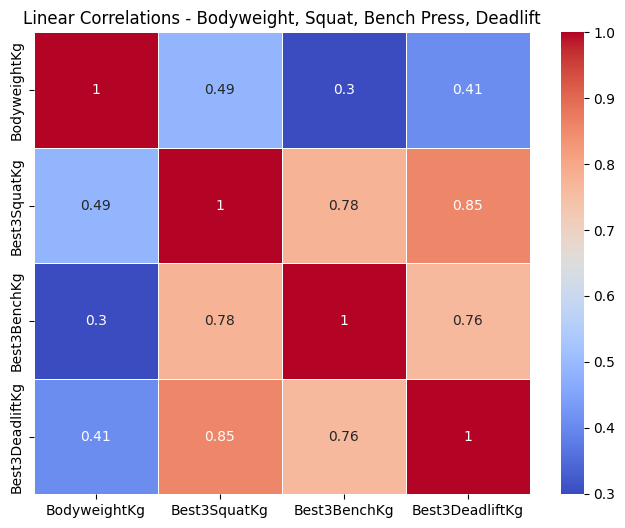

In [ ]:
correlation_matrix('F', 'Raw')

**Bodyweight vs. Lifts**:

*BodyweightKg vs. Best3SquatKg (0.488)*: There is a moderate positive correlation between a lifter’s bodyweight and their best squat performance. This means that, on average, as bodyweight increases, so does squat performance.

*BodyweightKg vs. Best3BenchKg (0.299)*: There is a weak positive correlation between bodyweight and best bench press performance. As bodyweight increases, bench press performance tends to increase, but the relationship is not very strong.

*BodyweightKg vs. Best3DeadliftKg (0.408)*: A moderate positive correlation is observed between bodyweight and best deadlift performance. As bodyweight increases, deadlift performance tends to increase as well.

**Lifts vs. Each Other**:

*Best3SquatKg vs. Best3BenchKg (0.777)*: There is a strong positive correlation between best squat and best bench press performance. Lifters who perform well in squats tend to perform well in bench presses.

*Best3SquatKg vs. Best3DeadliftKg (0.855)*: There is a very strong positive correlation between best squat and best deadlift performance. Lifters who perform well in squats also tend to perform well in deadlifts.

*Best3BenchKg vs. Best3DeadliftKg (0.764)*: There is a strong positive correlation between best bench press and best deadlift performance. Lifters who perform well in bench presses also tend to perform well in deadlifts.

### Female, Single-Ply

                 BodyweightKg  Best3SquatKg  Best3BenchKg  Best3DeadliftKg
BodyweightKg         1.000000      0.334217      0.363725         0.352971
Best3SquatKg         0.334217      1.000000      0.842295         0.824860
Best3BenchKg         0.363725      0.842295      1.000000         0.761087
Best3DeadliftKg      0.352971      0.824860      0.761087         1.000000


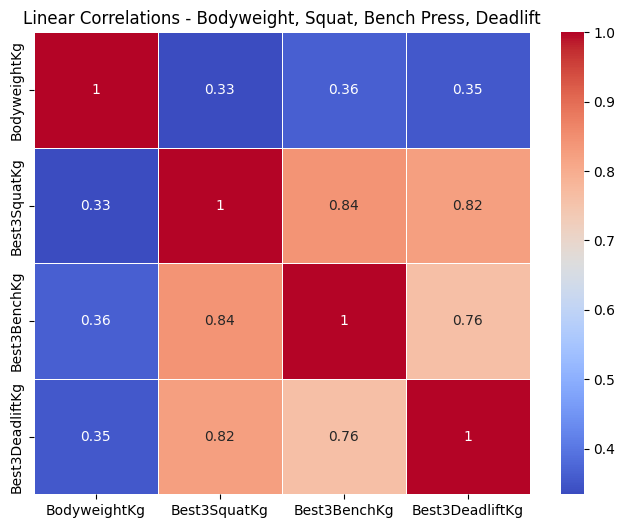

In [ ]:
correlation_matrix('F', 'Single-ply')

**Bodyweight vs. Lifts**:

*BodyweightKg vs. Best3SquatKg (0.334)*: There is a weak positive correlation between a lifter’s bodyweight and their best squat performance. This means that, on average, as bodyweight increases, so does squat performance, but the relationship is not very strong.

*BodyweightKg vs. Best3BenchKg (0.364)*: There is a weak positive correlation between bodyweight and best bench press performance. As bodyweight increases, bench press performance tends to increase, but the relationship is not very strong.

*BodyweightKg vs. Best3DeadliftKg (0.353)*: A weak positive correlation is observed between bodyweight and best deadlift performance. As bodyweight increases, deadlift performance tends to increase, but the relationship is not very strong.

**Lifts vs. Each Other**:

*Best3SquatKg vs. Best3BenchKg (0.842)*: There is a strong positive correlation between best squat and best bench press performance. Lifters who perform well in squats tend to perform well in bench presses.

*Best3SquatKg vs. Best3DeadliftKg (0.825)*: There is a strong positive correlation between best squat and best deadlift performance. Lifters who perform well in squats also tend to perform well in deadlifts.

*Best3BenchKg vs. Best3DeadliftKg (0.761)*: There is a strong positive correlation between best bench press and best deadlift performance. Lifters who perform well in bench presses also tend to perform well in deadlifts.

### **Correlation Conclusion**

**Bodyweight and Lift Performance**: For both genders and across different equipment types, there is a positive correlation between bodyweight and lift performance. This means that as a lifter’s bodyweight increases, their performance in squats, bench presses, and deadlifts tends to increase as well. However, the strength of this correlation varies. For male lifters using raw equipment or single-ply equipment, the correlation is moderate to strong. For female lifters, the correlation is weaker, especially for those using single-ply equipment.

**Lift Performance Across Different Lifts**: There is a strong positive correlation between the performance of different lifts. This means that if a lifter performs well in one type of lift (e.g., squat), they are likely to perform well in the other types (e.g., bench press and deadlift) as well. This correlation is strong for both genders and across different equipment types. However, it is slightly stronger for male lifters compared to female lifters.

**Impact of Equipment Type**: The type of equipment used (raw vs. single-ply) also seems to have an impact on these correlations. For both male and female lifters, the correlations are generally stronger when using raw equipment compared to single-ply equipment. This could suggest that the use of equipment might level the playing field to some extent, reducing the impact of bodyweight on lift performance.

In summary, these correlations suggest that while bodyweight and the type of equipment used do have an impact on lift performance, the lifter’s overall strength and skill level (as indicated by their performance across different lifts) is also a crucial factor. However, it’s important for us to remember that correlation does not imply causation, and these results could be influenced by other factors not included in the analysis.

### 10. **Find repeating users**

#### **Similar names**

We use fuzzy string matching libraries like fuzzywuzzy to find similar names. This library uses Levenshtein Distance to calculate the differences between sequences (names in this case).

In [ ]:
# Function to get similar names using fuzzy matching
# For each name, find other names with similarity score > 90
# calling this list all_names for now because even names with no other names
# similar to them will also be added
def get_similar_names(dataframe):
    unique_names = dataframe["Name"].astype(str).unique()
    all_similar_names = []

    for name in unique_names:
        matches = process.extract(name, unique_names, limit=100, scorer=fuzz.token_sort_ratio)
        similar_matches = [m[0] for m in matches if m[1] > 90]  # Filter by similarity score
        all_similar_names.append(similar_matches)

    all_similar_names.sort()
    return all_similar_names

In [ ]:
all_similar_names = get_similar_names(df)

In [ ]:
all_similar_names

When investigating if a powerlifter has a name (name and surname) similar to his/hers in the dataset, fuzzywuzzy will return a list, starting with that person's name at the 0th index, then the similar names follow. If that person's name has no similar matches, it'll be the only name in the list. Hence we will now collect all names lists with length > 1 to create the list of all similar names in the dataset

In [ ]:
# Function to find unique lists of similar names
def find_unique_lists(all_similar_names):
    similar_names = [names for names in all_similar_names if len(names) > 1]
    unique_lists = set()

    for inner_list in similar_names:
        inner_tuple = tuple(sorted(inner_list))
        if not all(x == inner_tuple[0] for x in inner_tuple):
            unique_lists.add(inner_tuple)

    unique_lists = [list(inner_tuple) for inner_tuple in unique_lists]

    # Flatten the list
    unique_lists = [item for sublist in unique_lists for item in sublist]
    return unique_lists

In [ ]:
unique_lists = find_unique_lists(all_similar_names=all_similar_names)
unique_lists

['Aisha Al Suwadi',
 'Aisha Al Suwaidi',
 'Abdulrahman Al Saadi',
 'Abdulrahman Saadi',
 'Oneil Williams',
 'Oniel Williams',
 'Xavier McCarthy',
 'Xavier Mccarty',
 'Mohamed Alaradi',
 'Mohammed Al Aradi',
 'Yosuke Kikuchi',
 'Yosuke Kiuchi',
 'Jonhoi Vaugh',
 'Jonhoi Vaughn',
 'Viktoria Nahnoina',
 'Viktoriia Nahnoina']

It seems like some people's names were entered differently, or misspelled, for example: `Abdulrahman Al Saadi`, `Abdulrahman Saadi` and `Viktoria Nahnoina`, '`Viktoriia Nahnoina`.

We investigate if these names belong to the same person or not

Now, unique_names is a list of all the unique names from the `similar_names` list. We now use this list to filter our DataFrame and check for duplicates:

In [ ]:
# Get rows where name is in unique_names
df_filtered = df[df["Name"].isin(unique_lists)]
df_filtered

,Name,JapaneseName,Team,Sex,Division,BodyweightKg,WeightClassKg,BirthYear,Bench1Kg,Bench2Kg,...,Deadlift3Kg,Best3SquatKg,Best3DeadliftKg,Age,Squat4Kg,Bench4Kg,Deadlift4Kg,Country,Wilks,IPF
120,Yosuke Kikuchi,菊地 洋介,神奈川 K’s GYM 横浜,M,Open,82.45,83.00,1995.0,-272.50,272.50,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,219.286267,31.590256
1147,Yosuke Kiuchi,木内 陽介,東京都パワーハウス,M,Open,65.55,66.00,1996.0,165.00,-175.00,...,282.50,270.00,282.50,NaN,NaN,NaN,NaN,NaN,679.543226,97.921621
1201,Yosuke Kiuchi,木内 陽介,東京都パワーハウス,M,Juniors,65.55,66.00,1996.0,165.00,-175.00,...,282.50,270.00,282.50,NaN,NaN,NaN,NaN,NaN,679.543226,97.921621
1409,Yosuke Kikuchi,菊地 洋介,神奈川県 K’sGYM横浜,M,Open,82.25,83.00,1995.0,-275.00,275.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,243.770650,35.118180
1573,Yosuke Kiuchi,木内 陽介,青山学院大学,M,Student,69.10,74.00,1996.0,125.00,135.00,...,292.50,220.00,292.50,NaN,NaN,NaN,NaN,NaN,587.375718,99.282685
2663,Yosuke Kiuchi,木内 陽介,青山学院大学,M,Open,65.60,66.00,1996.0,165.00,177.50,...,-278.00,272.50,265.00,NaN,NaN,NaN,NaN,NaN,674.505542,97.195593
2756,Yosuke Kiuchi,木内 陽介,青山学院大学,M,Juniors,65.55,66.00,1996.0,150.00,165.00,...,277.50,267.50,277.50,NaN,NaN,NaN,NaN,NaN,663.196826,95.566118
2810,Yosuke Kiuchi,木内 陽介,春日部共栄高,M,High School,64.30,66.00,NaN,105.00,110.00,...,225.00,195.00,225.00,NaN,NaN,NaN,NaN,NaN,506.697578,84.559204
3200,Yosuke Kikuchi,菊地 洋介,K's GYM横浜,M,Juniors,72.20,74.00,1995.0,140.00,147.50,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,133.274630,22.677100
3949,Yosuke Kikuchi,菊地 洋介,K's GYM 横浜,M,Open,82.15,83.00,1995.0,170.00,180.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,145.156105,25.046851


In [ ]:
# Check if all other columns are the same for these names
duplicates = df_filtered.duplicated(subset=df.columns.difference(['Name']), keep=False)
# Create a new DataFrame with only the duplicated rows
df_duplicates = df_filtered[duplicates]
df_duplicates

,Name,JapaneseName,Team,Sex,Division,BodyweightKg,WeightClassKg,BirthYear,Bench1Kg,Bench2Kg,...,Deadlift3Kg,Best3SquatKg,Best3DeadliftKg,Age,Squat4Kg,Bench4Kg,Deadlift4Kg,Country,Wilks,IPF


Now, df_duplicates is a DataFrame that should contain only the rows from df where the name is in unique_names and all columns (except for the name) are duplicated. However, df_duplicates is empty, meaning that there are no two rows where the name is in unique_names and all other details (like age, weight class, country, etc.) are exactly the same.

This could mean a few things:

***The names represent different individuals***: If all other details (like age, weight class, country, etc.) are different for each name, it’s likely that the names represent different individuals.

***The data was recorded inconsistently***: If there are slight differences in how the data was recorded (for example, if the weight class was recorded differently for the same individual in different rows), it could cause this method to not detect duplicates.

***This is hard to tell since our dataset is missing a few columns***

#### We repeat the above process with the complete dataset

NB: Most of the code is commented out because the new dataframe is quite large and re-running the commented cells takes a really long time. Hence after one run, the required filtered dataset was obtained and saved as a csv. Hence, for reproducibility, just read in `df_filtered.csv`

The complete dataset has a lot more lifters than our above `df` and has more columns that could be useful to determine of n rows represent the same lifter or not, e.g the `Date` column. It could be the date they registered and partook in the competition.

In [ ]:
# df_complete = pd.read_csv("/content/drive/MyDrive/openpowerlifting-2023-09-02-6fa372dd.csv", low_memory=False)

In [ ]:
# federations = ['JPA', 'UAEPA', 'NPAJ']
# df_comp = df_complete[df_complete['Federation'].isin(federations)]
# df_comp

In [ ]:
# # Get unique names
# df_unique_names = df_comp["Name"].astype(str).unique()
# len(df_unique_names)

In [ ]:
# df_unique_names

In [ ]:
# # For each name, find other names with similarity score > 90
# # calling this list all_names for now because even names with no other names
# # similar to them will also be added
# all_names = []
# for i, name in enumerate(df_unique_names):
#   print("{}. {}".format((i+1), name))
#   matches = process.extract(name, df_unique_names, limit=100, scorer=fuzz.token_sort_ratio)
#   similar_matches = []
#   for m in matches:
#     if m[1] > 90: # the similarity score
#       similar_matches.append(m[0])
#   all_names.append(similar_matches)

In [ ]:
# # sort the list
# all_names.sort()

In [ ]:
# similar_names = []
# for list_names in all_names:
#   if len(list_names) > 1:
#     similar_names.append(list_names)

# similar_names

In [ ]:
# # Flatten the list
# flat_list = [item for sublist in similar_names for item in sublist]

# # Remove duplicates
# unique_names = list(set(flat_list))
# unique_names

In [ ]:
# # Get rows where name is in unique_names
# df_filtered = df_comp[df_comp["Name"].isin(unique_names)]
# df_filtered

In [ ]:
# df_filtered.to_csv(path_or_buf="/content/drive/MyDrive/df_filtered.csv")

We finally have a dataframe with powerlifters from our selected Federations again

In [ ]:
df_filtered_ii = pd.read_csv("/content/drive/MyDrive/df_filtered.csv")
sorted_df = df_filtered_ii.sort_values(by=["Name"])

In [ ]:
# Check if all other columns are the same for these names
duplicates = df_filtered_ii.duplicated(subset=df_filtered_ii.columns.difference(["Name"]), keep=False)
# Create a new DataFrame with only the duplicated rows
df_duplicates = df_filtered_ii[duplicates]
df_duplicates.size

0

Again, `df_duplicates` is empty because no two rows, even if they're representing the same person, can ever be the same. A person's body weight might change each time they weigh in when registering, the date in which they register for different events will not be the same, the meet name they register under may change etc.

How then do we tell two people apart? 🤔

For example, `A. Ito` and `A. Itoh`.



*   Row `267` says this person is female, hence she participated in the `Japanese Women's Nationals`, whereas most of the rows say he's a male and the `Meet Name`s they participated in don't mention gender.
*   It seems like this lifter first participated in `1981-03-22`, and they weighed `67.5`. In the same year `1981-10-11`, they weighed `75.0`. Then, from the year `1985-03-17` going forward, they maintained a weight of `56.0`

Is this one person?


Worst case scenario we'll have to check each person in a similar fashion. Is there a way we could do this in a better way?

In [ ]:
def get_similar_names(dataframe):

    unique_names = dataframe["Name"].astype(str).unique()
    all_similar_names = ["nobody"]

    for name in unique_names:
        matches = process.extract(name, unique_names, limit=100, scorer=fuzz.token_sort_ratio)
        similar_matches = [m[0] for m in matches if m[1] > 90]  # Filter by similarity score
        if np.flip(similar_matches).tolist() == all_similar_names[len(all_similar_names)-1]:
          continue
        all_similar_names.append(similar_matches)

    all_similar_names.remove("nobody")
    all_similar_names.sort()
    return all_similar_names

In [ ]:
# Function to find unique lists of similar names
def find_unique_lists(all_similar_names):
    similar_names = [names for names in all_similar_names if len(names) > 1]
    unique_lists = set()

    for inner_list in similar_names:
        inner_tuple = tuple(sorted(inner_list))
        if not all(x == inner_tuple[0] for x in inner_tuple):
            unique_lists.add(inner_tuple)

    unique_lists = [list(inner_tuple) for inner_tuple in unique_lists]
    return unique_lists

In [ ]:
cols_with_no_nulls = []
for col in df_filtered_ii.columns:
  if df_filtered_ii[col].isnull().sum() == 0:
    cols_with_no_nulls.append(col)

cols_with_no_nulls

['Unnamed: 0',
 'Name',
 'Sex',
 'Event',
 'Equipment',
 'Division',
 'WeightClassKg',
 'Place',
 'Tested',
 'Federation',
 'ParentFederation',
 'Date',
 'MeetCountry',
 'MeetName']

In [ ]:
# Function to check if two names are the same person based on criteria
def is_same_person(name1, name2, df):
    data1 = df[df['Name'] == name1]
    data2 = df[df['Name'] == name2]

    count = 0

    total_kg_threshold = 10  # Adjust as needed
    if abs(data1['WeightClassKg'].values[0] - data2['WeightClassKg'].values[0]) <= total_kg_threshold:
        count += 1 #return True

    if data1['MeetCountry'].values[0] == data2['MeetCountry'].values[0]:
        count += 1 # return True

    if data1['Sex'].values[0] == data2['Sex'].values[0]:
        count += 1

    if data1['Division'].values[0] == data2['Division'].values[0]:
        count += 1

    if count == 4: return True
    else: return False

In [ ]:
df_filtered_ii["WeightClassKg"] = df_filtered_ii["WeightClassKg"].str.replace("+", "").str.replace("-", "").astype(float)

<ipython-input-12-1045381c9444>:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df_filtered_ii["WeightClassKg"] = df_filtered_ii["WeightClassKg"].str.replace("+", "").str.replace("-", "").astype(float)


In [ ]:
all_similar_names = get_similar_names(df_filtered_ii)

In [ ]:
for names in all_similar_names:
    for i in range(len(names)):
        for j in range(i + 1, len(names)):
            if is_same_person(names[i], names[j], df_filtered_ii):
                print(f"{names[i]} and {names[j]} are likely the same person.")

Aisha Al Suwadi and Aisha Al Suwaidi are likely the same person.
Aisha Al Suwaidi and Aisha Al Suwadi are likely the same person.
B. Sato and B. Satoh are likely the same person.
B. Satoh and B. Sato are likely the same person.
C. Ito and C. Itoh are likely the same person.
C. Itoh and C. Ito are likely the same person.
C. Mizaguchi and C. Mizoguchi are likely the same person.
C. Mizoguchi and C. Mizaguchi are likely the same person.
C. Wakushima and G. Wakushima are likely the same person.
G. Matsubara and K. Matsubara are likely the same person.
E. Saitoh and E. Satoh are likely the same person.
E. Satoh and E. Saitoh are likely the same person.
G. Matsubara and K. Matsubara are likely the same person.
G. Wakushima and C. Wakushima are likely the same person.
H. Hishihara and H. Nishihara are likely the same person.
H. Ito and H. Itoh are likely the same person.
H. Itoh and H. Ito are likely the same person.
H. Nishihara and H. Hishihara are likely the same person.
Jonhoi Vaugh and J